<a href="https://colab.research.google.com/github/cinumell/stock_price_prediction_Deep_Learning/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price prediction of a company using LSTM, Simple RNN, GRU & RF models

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

TensorFlow version: 2.10.0
Num GPUs Available:  1
Num CPUs Available:  1


Base case error for open = 4.550830772989606
Base case error for close = 4.531032878396391
Base case error for high = 4.498310658258072
Base case error for low = 4.570374371139862


/var/folders/p6/vpj9j15x7774phthzn6s023m0000gn/T/ipykernel_19412/3493795175.py:17: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data = pr.get_data_tiingo(company, api_key="0f6351ae343427e511f4d085681db7e303ffb969")


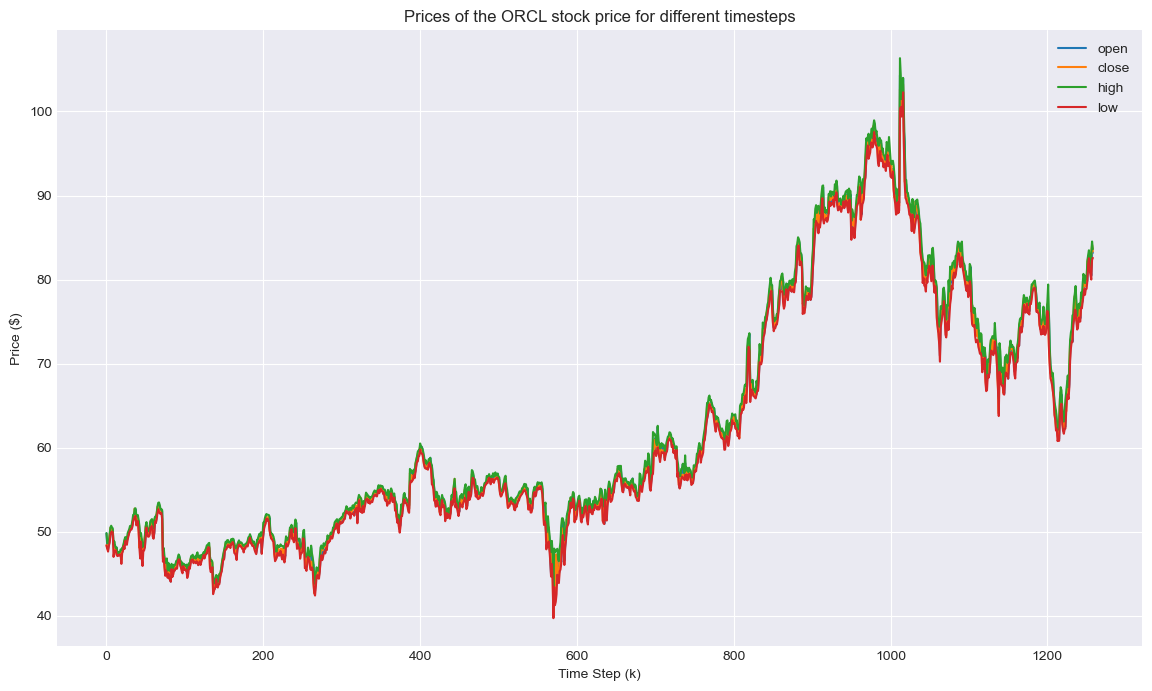

In [10]:
# Dataset download
import pandas_datareader as pr
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

step = 70 # time step
company = 'ORCL'
price_type = 'close'


#plt.style.use('fivethirtyeight')
plt.style.use('seaborn-darkgrid')

fig,ax = plt.subplots(figsize=(14,8))
data = pr.get_data_tiingo(company, api_key="0f6351ae343427e511f4d085681db7e303ffb969")
data.to_csv(company+'.csv')

data = pd.read_csv(company+'.csv')
# Baseline calculation
Base_errors = []

for types in ['open','close','high','low']:

  Price = data[types]
  Means = list()

  for i in range(len(Price) - step):
    Means.append(sum(Price[i:i+step])/step)  

  Error = math.sqrt(mean_squared_error(Price[step:],Means))
  Base_errors.append(Error)   
  print("Base case error for",types,"=",Error)    
  ax.plot(Price,label=types)
 
#Customize
ax.set(title=f'Prices of the {company} stock price for different timesteps', 
       ylabel='Price ($)',
       xlabel='Time Step (k)')
ax.legend()
Price = data[price_type]

In [11]:
data

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,ORCL,2017-12-04 00:00:00+00:00,48.40,49.820,48.360,49.82,13352194,44.578597,45.886481,44.541755,45.886481,13352194,0.0,1.0
1,ORCL,2017-12-05 00:00:00+00:00,47.99,48.650,47.965,48.21,17742443,44.200968,44.808858,44.177942,44.403598,17742443,0.0,1.0
2,ORCL,2017-12-06 00:00:00+00:00,48.42,48.585,47.630,47.88,12937589,44.597018,44.748990,43.869392,44.099653,12937589,0.0,1.0
3,ORCL,2017-12-07 00:00:00+00:00,48.52,48.810,48.300,48.37,13410242,44.689122,44.956225,44.486492,44.550965,13410242,0.0,1.0
4,ORCL,2017-12-08 00:00:00+00:00,49.60,49.690,48.700,48.90,14404743,45.683851,45.766745,44.854910,45.039120,14404743,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,ORCL,2022-11-28 00:00:00+00:00,81.39,82.140,81.070,82.11,5113103,81.390000,82.140000,81.070000,82.110000,5113103,0.0,1.0
1255,ORCL,2022-11-29 00:00:00+00:00,80.85,81.500,80.520,81.33,4928270,80.850000,81.500000,80.520000,81.330000,4928270,0.0,1.0
1256,ORCL,2022-11-30 00:00:00+00:00,83.03,83.175,80.000,80.47,9610329,83.030000,83.175000,80.000000,80.470000,9610329,0.0,1.0
1257,ORCL,2022-12-01 00:00:00+00:00,84.11,84.530,82.350,83.05,6127308,84.110000,84.530000,82.350000,83.050000,6127308,0.0,1.0


In [12]:
# MinMax Scalimg
import numpy as np
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler(feature_range=(0,1))
Price = mms.fit_transform(np.array(Price).reshape(-1,1))

# Dataset split into train and test sets

train_size = int(len(Price)*0.80)
test_size = len(Price)-train_size
train_data,test_data = Price[0:train_size,:],Price[train_size:len(Price),:1]
train_size, test_size

(1007, 252)

In [13]:
# Converting data to timeseries input

def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

time_step = step
trainX, trainY = create_dataset(train_data, time_step)
testX, testY = create_dataset(test_data, time_step)

print(trainX.shape), print(trainY.shape)
print(testX.shape), print(testY.shape)

trainX_2d = trainX
testX_2d = testX

trainX = trainX.reshape(trainX.shape[0],trainX.shape[1] , 1)
testX = testX.reshape(testX.shape[0],testX.shape[1] , 1)

(936, 70)
(936,)
(181, 70)
(181,)


# RandomForestRegressor Ensembler Model

In [14]:
# Import the RandomForestRegressor model class from the ensemble module
from sklearn.ensemble import RandomForestRegressor

# Setup random seed
np.random.seed(42)

# Institate and fit the model (on the training set)
model = RandomForestRegressor()
model.fit(trainX_2d, trainY)

RandomForestRegressor()

# Stacked LSTM model

The operation of an LSTM is somewhat similar to that of an RNN with some differences. The processes that take place inside of cells of LSTM are what set them apart. The states of the cell and numerous gates are essential components of an LSTM model. The cell states are the ones in charge of conveying information that is relevant from the beginning to the finishing stages of the process. The above problem of c ntaining just short-term memory is resolved by the fact that information from previous states is carry forwarded over to subsequent ones. The LSTM gates are made up of various separate neural networks, wherein each of the neural networks determines whether or not the information in question is required. Sigmoid function and Tanh function are considered to be the two primary activation functions in this model. Instead of being between -1 and 1 (because of Tanh function), the result is compressed by the sigmoid function to be in between 0 and 1.

In [15]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

lstm = Sequential()
lstm.add(LSTM(128, return_sequences=True, input_shape= (step, 1)))
lstm.add(LSTM(64, return_sequences=False))
lstm.add(Dense(25))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.summary()

2022-12-02 19:24:03.164319: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-02 19:24:03.164658: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 70, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [16]:
lstm.fit(trainX,trainY,validation_data=(testX,testY),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


2022-12-02 19:24:03.689140: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-02 19:24:05.031857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:24:05.179431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:24:05.339310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:24:05.532396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:24:05.812477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.0162

2022-12-02 19:24:07.386421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:24:07.437050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:24:07.543224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 4s 130ms/step - loss: 0.0162 - val_loss: 0.0031
Epoch 2/100
15/15 [==============================] - 1s 45ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 3/100
15/15 [==============================] - 1s 48ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 4/100
15/15 [==============================] - 1s 44ms/step - loss: 9.6323e-04 - val_loss: 0.0028
Epoch 5/100
15/15 [==============================] - 1s 43ms/step - loss: 8.7310e-04 - val_loss: 0.0027
Epoch 6/100
15/15 [==============================] - 1s 43ms/step - loss: 8.7520e-04 - val_loss: 0.0027
Epoch 7/100
15/15 [==============================] - 1s 43ms/step - loss: 8.9327e-04 - val_loss: 0.0033
Epoch 8/100
15/15 [==============================] - 1s 43ms/step - loss: 9.0983e-04 - val_loss: 0.0027
Epoch 9/100
15/15 [==============================] - 1s 43ms/step - loss: 8.5852e-04 - val_loss: 0.0024
Epoch 10/100
15/15 [==============================] - 1s 43ms/step - loss: 7.9490e-04 -

15/15 [==============================] - 1s 43ms/step - loss: 3.3704e-04 - val_loss: 9.1941e-04
Epoch 79/100
15/15 [==============================] - 1s 50ms/step - loss: 3.4311e-04 - val_loss: 7.6146e-04
Epoch 80/100
15/15 [==============================] - 1s 43ms/step - loss: 3.1721e-04 - val_loss: 6.9568e-04
Epoch 81/100
15/15 [==============================] - 1s 42ms/step - loss: 3.1520e-04 - val_loss: 7.1309e-04
Epoch 82/100
15/15 [==============================] - 1s 42ms/step - loss: 3.0849e-04 - val_loss: 8.3669e-04
Epoch 83/100
15/15 [==============================] - 1s 42ms/step - loss: 3.4737e-04 - val_loss: 6.8980e-04
Epoch 84/100
15/15 [==============================] - 1s 42ms/step - loss: 3.0790e-04 - val_loss: 6.7370e-04
Epoch 85/100
15/15 [==============================] - 1s 43ms/step - loss: 3.2473e-04 - val_loss: 7.7078e-04
Epoch 86/100
15/15 [==============================] - 1s 48ms/step - loss: 3.2449e-04 - val_loss: 6.8094e-04
Epoch 87/100
15/15 [============

# Simple RNN

The RNN begins by converting words into vectors that can be read by machines. After that, the RNN will process each individual vector in this sequence in order. During the course of computing these vectors, the prior concealed states are brought together with the present state. The vector is now made up of the most recent input as well as the input from before. The tanh activation function is now applied to this merged vector before the process is complete. The outcome of the tan function is used as the network's new hidden state or memory after being processed by it. The outcome of the neural network is controlled by a tanh function, which assures that the values are maintained within the range of -1 to 1.

In [17]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense

rnn = Sequential()
rnn.add(LSTM(128, return_sequences=True, input_shape= (step, 1)))
rnn.add(LSTM(64, return_sequences=False))
rnn.add(Dense(25))
rnn.add(Dense(1))
rnn.compile(optimizer='adam', loss='mean_squared_error')
rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 70, 128)           66560     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 25)                1625      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [18]:
rnn.fit(trainX,trainY,validation_data=(testX,testY),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


2022-12-02 19:25:14.791164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:25:14.931195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:25:15.051318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:25:15.209927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:25:15.443766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.0242

2022-12-02 19:25:17.094399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:25:17.146944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:25:17.259758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 4s 136ms/step - loss: 0.0242 - val_loss: 0.0073
Epoch 2/100
15/15 [==============================] - 1s 46ms/step - loss: 0.0023 - val_loss: 0.0037
Epoch 3/100
15/15 [==============================] - 1s 44ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 4/100
15/15 [==============================] - 1s 46ms/step - loss: 9.7546e-04 - val_loss: 0.0028
Epoch 5/100
15/15 [==============================] - 1s 44ms/step - loss: 9.0318e-04 - val_loss: 0.0028
Epoch 6/100
15/15 [==============================] - 1s 44ms/step - loss: 8.9888e-04 - val_loss: 0.0028
Epoch 7/100
15/15 [==============================] - 1s 44ms/step - loss: 8.4570e-04 - val_loss: 0.0027
Epoch 8/100
15/15 [==============================] - 1s 43ms/step - loss: 8.3372e-04 - val_loss: 0.0026
Epoch 9/100
15/15 [==============================] - 1s 44ms/step - loss: 8.8390e-04 - val_loss: 0.0030
Epoch 10/100
15/15 [==============================] - 1s 44ms/step - loss: 8.9263e-04 -

15/15 [==============================] - 1s 48ms/step - loss: 3.3712e-04 - val_loss: 6.8698e-04
Epoch 79/100
15/15 [==============================] - 1s 49ms/step - loss: 2.8072e-04 - val_loss: 6.4865e-04
Epoch 80/100
15/15 [==============================] - 1s 49ms/step - loss: 2.7480e-04 - val_loss: 6.4170e-04
Epoch 81/100
15/15 [==============================] - 1s 58ms/step - loss: 2.6866e-04 - val_loss: 6.4283e-04
Epoch 82/100
15/15 [==============================] - 1s 52ms/step - loss: 3.1419e-04 - val_loss: 6.3906e-04
Epoch 83/100
15/15 [==============================] - 1s 51ms/step - loss: 2.9021e-04 - val_loss: 6.2076e-04
Epoch 84/100
15/15 [==============================] - 1s 53ms/step - loss: 2.6434e-04 - val_loss: 6.1531e-04
Epoch 85/100
15/15 [==============================] - 1s 48ms/step - loss: 2.8456e-04 - val_loss: 6.0991e-04
Epoch 86/100
15/15 [==============================] - 1s 48ms/step - loss: 2.8800e-04 - val_loss: 7.5510e-04
Epoch 87/100
15/15 [============

# GRU

As GRUs need fewer tensor operations than LSTMs do, it takes GRUs somewhat less time to be trained than LSTMs. There is no single option that stands out as the superior choice. Scientists and technologists will often test out both options in order to decide whether one functions more effectively for a certain application scenario.

In [19]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

gru = Sequential()
gru.add(LSTM(128, return_sequences=True, input_shape= (step, 1)))
gru.add(LSTM(64, return_sequences=False))
gru.add(Dense(25))
gru.add(Dense(1))
gru.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 70, 128)           66560     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 25)                1625      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [20]:
gru.fit(trainX,trainY,validation_data=(testX,testY),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


2022-12-02 19:26:30.292314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:26:30.437857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:26:30.618389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:26:30.877001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:26:31.176432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.0807

2022-12-02 19:26:33.290012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:26:33.352994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:26:33.469068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 5s 168ms/step - loss: 0.0807 - val_loss: 0.1181
Epoch 2/100
15/15 [==============================] - 1s 53ms/step - loss: 0.0291 - val_loss: 0.0242
Epoch 3/100
15/15 [==============================] - 1s 49ms/step - loss: 0.0077 - val_loss: 0.0050
Epoch 4/100
15/15 [==============================] - 1s 52ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 5/100
15/15 [==============================] - 1s 53ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 6/100
15/15 [==============================] - 1s 51ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 7/100
15/15 [==============================] - 1s 51ms/step - loss: 0.0010 - val_loss: 0.0039
Epoch 8/100
15/15 [==============================] - 1s 52ms/step - loss: 0.0010 - val_loss: 0.0041
Epoch 9/100
15/15 [==============================] - 1s 50ms/step - loss: 0.0010 - val_loss: 0.0043
Epoch 10/100
15/15 [==============================] - 1s 51ms/step - loss: 0.0010 - val_loss: 0.0042
Epoch 11/1

15/15 [==============================] - 1s 49ms/step - loss: 9.4486e-04 - val_loss: 0.0032
Epoch 81/100
15/15 [==============================] - 1s 47ms/step - loss: 9.2485e-04 - val_loss: 0.0032
Epoch 82/100
15/15 [==============================] - 1s 48ms/step - loss: 9.3644e-04 - val_loss: 0.0033
Epoch 83/100
15/15 [==============================] - 1s 48ms/step - loss: 9.1179e-04 - val_loss: 0.0034
Epoch 84/100
15/15 [==============================] - 1s 49ms/step - loss: 9.1896e-04 - val_loss: 0.0033
Epoch 85/100
15/15 [==============================] - 1s 47ms/step - loss: 9.1722e-04 - val_loss: 0.0033
Epoch 86/100
15/15 [==============================] - 1s 47ms/step - loss: 9.0807e-04 - val_loss: 0.0033
Epoch 87/100
15/15 [==============================] - 1s 51ms/step - loss: 9.1287e-04 - val_loss: 0.0034
Epoch 88/100
15/15 [==============================] - 1s 50ms/step - loss: 9.0825e-04 - val_loss: 0.0034
Epoch 89/100
15/15 [==============================] - 1s 50ms/step -

## Performance Evaluation using RNN, LSTM, GRU models

The predictions from every model are mostly accurate. When compared to the other two models, however, LSTM is clearly the winner. However, our rigorous testing has led us to the conclusion that the LSTM model is the most effective.

2022-12-02 19:27:46.884815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:27:46.964184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 3/30 [==>...........................] - ETA: 0s 

2022-12-02 19:27:47.088109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 55ms/step


2022-12-02 19:27:48.902547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:27:48.955968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:27:49.073051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 55ms/step


2022-12-02 19:27:50.644084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:27:50.694317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:27:50.809609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 53ms/step
Shape of LSTM test (181, 1)
Shape of RNN test (181, 1)
Shape of GRU test (181, 1)
Shape of RandomForestRegressor test (181,)
[79.96]
[52.27]
[52.352657]
[80.1495]
Train data error for LSTM model = 1.005084738155095
Test data error for LSTM model= 1.5492148122392453
----------------------------------------------------------------------
Train data error for RNN model = 1.0127243789308584
Test data error for RNN model= 1.5145336045604771
----------------------------------------------------------------------
Train data error for GRU model = 1.9015666605038564
Test data error for GRU model= 3.6469486711191164
----------------------------------------------------------------------
Train data error for RF model = 60.69985536974739
Test data error for RF model= 73.504438768199


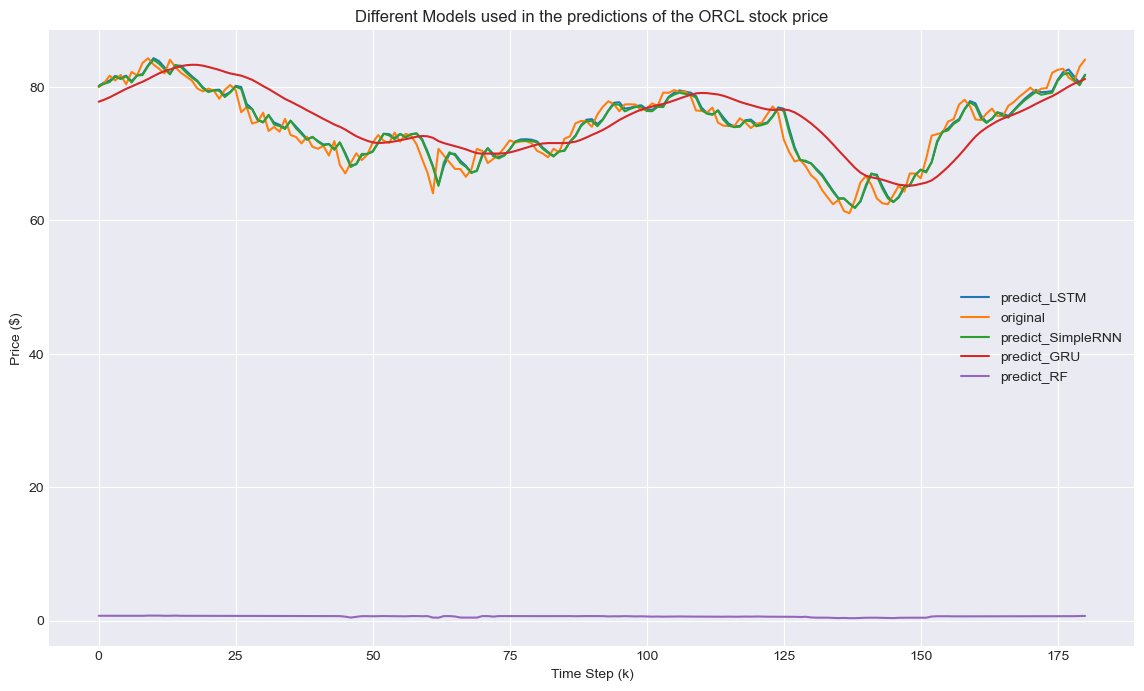

In [21]:
# Prediction and error calculation for lstm

train_predict_lstm = lstm.predict(trainX)
test_predict_lstm = lstm.predict(testX)

train_predict_rnn = rnn.predict(trainX)
test_predict_rnn = rnn.predict(testX)

train_predict_gru = gru.predict(trainX)
test_predict_gru = gru.predict(testX)

train_predict_rf = model.predict(trainX_2d)
test_predict_rf = model.predict(testX_2d)


print("Shape of LSTM test",test_predict_lstm.shape)
print("Shape of RNN test",test_predict_rnn.shape)
print("Shape of GRU test",test_predict_gru.shape)
print("Shape of RandomForestRegressor test",test_predict_rf.shape)

testY_lstm = testY.reshape(test_size-step-1,1)
trainY_lstm = trainY.reshape(train_size-step-1,1)

testY_rnn = testY.reshape(test_size-step-1,1)
trainY_rnn = trainY.reshape(train_size-step-1,1)

testY_gru = testY.reshape(test_size-step-1,1)
trainY_gru = trainY.reshape(train_size-step-1,1)

testY_rf = testY.reshape(test_size-step-1,1)
trainY_rf = trainY.reshape(train_size-step-1,1)

testY_lstm = mms.inverse_transform(testY_lstm)
trainY_lstm = mms.inverse_transform(trainY_lstm)

testY_rnn = mms.inverse_transform(testY_rnn)
trainY_rnn = mms.inverse_transform(trainY_rnn)

testY_gru = mms.inverse_transform(testY_gru)
trainY_gru = mms.inverse_transform(trainY_gru)

testY_rf = mms.inverse_transform(testY_rf)
trainY_rf = mms.inverse_transform(trainY_rf)

print(testY_lstm[0])
print(trainY_lstm[0])

train_predict_lstm = mms.inverse_transform(train_predict_lstm)
test_predict_lstm = mms.inverse_transform(test_predict_lstm)
train_predict_rnn = mms.inverse_transform(train_predict_rnn)
test_predict_rnn = mms.inverse_transform(test_predict_rnn)
train_predict_gru = mms.inverse_transform(train_predict_gru)
test_predict_gru = mms.inverse_transform(test_predict_gru)

print(train_predict_lstm[0])
print(test_predict_lstm[0])

print("Train data error for LSTM model =",math.sqrt(mean_squared_error(trainY_lstm,train_predict_lstm)))
print("Test data error for LSTM model=",math.sqrt(mean_squared_error(testY_lstm,test_predict_lstm)))
print("----------------------------------------------------------------------")
print("Train data error for RNN model =",math.sqrt(mean_squared_error(trainY_rnn,train_predict_rnn)))
print("Test data error for RNN model=",math.sqrt(mean_squared_error(testY_rnn,test_predict_rnn)))
print("----------------------------------------------------------------------")
print("Train data error for GRU model =",math.sqrt(mean_squared_error(trainY_gru,train_predict_gru)))
print("Test data error for GRU model=",math.sqrt(mean_squared_error(testY_gru,test_predict_gru)))
print("----------------------------------------------------------------------")
print("Train data error for RF model =",math.sqrt(mean_squared_error(trainY_rf,train_predict_rf)))
print("Test data error for RF model=",math.sqrt(mean_squared_error(testY_rf,test_predict_rf)))

#plt.style.use('fivethirtyeight')
plt.style.use('seaborn-darkgrid')
fig,ax = plt.subplots(figsize=(14,8))
#Customize
ax.set(title=f'Different Models used in the predictions of the {company} stock price', 
       xlabel='Time Step (k)',
       ylabel='Price ($)')
ax.plot(test_predict_lstm,label = "predict_LSTM")
ax.plot(testY_lstm,label = "original")
ax.plot(test_predict_rnn,label = "predict_SimpleRNN")
ax.plot(test_predict_gru,label = "predict_GRU")
ax.plot(test_predict_rf, label ="predict_RF")
ax.legend()